## train 3D UNet on single molecule dataset with transfer learning

### load data

In [5]:
import os 
import numpy as np
from dataGenerator import imageLoader
import keras
import matplotlib.pyplot as plt
import glob
import random

In [6]:
# visualize
def visusalizeIMG(n_slice, test_img, test_msk):
    # n_slice = random.randint(0, test_img.shape[2])
    plt.figure(figsize=(8, 8))

    plt.subplot(121)
    plt.imshow(test_img[n_slice,:,:], cmap='gray')
    plt.title('focal slice')
    plt.subplot(122)
    plt.imshow(test_msk[n_slice,:,:], cmap='gray')
    plt.title('GT slice')
    plt.show()

In [7]:
# specify the dir

DATA_PATH = 'E:/EM/demo/3D_Unet_keras/inputData_3channels/'

train_img_dir = DATA_PATH + 'train/images/'
train_msk_dir = DATA_PATH + 'train/masks/'

train_img_list = sorted(glob.glob(train_img_dir + '/*.npy'))
train_msk_list = sorted(glob.glob(train_msk_dir + '/*.npy'))

num_images = len(train_img_list)
print(num_images)

240


In [11]:
# visualize the images

img_num = random.randint(0, num_images-1) # num从1开始
test_img = np.load(train_img_list[img_num])
test_img = test_img[...,0]
print('image shape:', test_img.shape)

test_mask = np.load(train_msk_list[img_num])
print('before mask:', test_mask.shape)
test_mask = np.argmax(test_mask, axis=3)
print('after mask:', test_mask.shape)


image shape: (64, 64, 64)
before mask: (64, 64, 64, 2)
after mask: (64, 64, 64)


current slice: 57


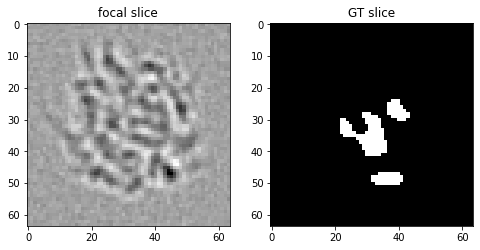

In [20]:
# visualize the images 
n_slice = random.randint(0, test_mask.shape[2]-1)
print('current slice:', n_slice)
visusalizeIMG(n_slice, test_img, test_mask)

### calculate the weight between labels. useful for weighted dice loss

In [21]:
import pandas as pd

columns = ['0', '1']
df = pd.DataFrame(columns=columns)

train_msk_list = sorted(glob.glob(train_msk_dir + '/*.npy'))

for img in range(len(train_msk_list)):
    
    # print(img)
    temp_image = np.load(train_msk_list[img])
    temp_image = np.argmax(temp_image, axis=3)  # convert back into images
    
    val, counts = np.unique(temp_image, return_counts=True) # count labels
    zipped = zip(columns, counts)
    counts_dict = dict(zipped)
    
    df = df.append(counts_dict, ignore_index = True)

In [22]:
# calculate the ratio of different labels

label_0 = df['0'].sum()
label_1 = df['1'].sum()

total_labels = label_0 + label_1
n_classes = 2

# class weight calculated: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) # 小数点后两位
wt1 = round((total_labels/(n_classes*label_1)), 2)

print(wt0, wt1)

0.56 4.4


### define the image generator

In [12]:
# data path

DATA_PATH = 'E:/EM/demo/3D_Unet_keras/inputData_3channels/'

# training
train_img_dir = DATA_PATH + 'train/images/'
train_msk_dir = DATA_PATH + 'train/masks/'

# train_img_list = sorted(glob.glob(train_img_dir + '/*.npy'))
# train_msk_list = sorted(glob.glob(train_msk_dir + '/*.npy'))

train_img_list = os.listdir(train_img_dir)
train_msk_list = os.listdir(train_msk_dir)

# validation
val_img_dir = DATA_PATH + 'val/images/'
val_msk_dir = DATA_PATH + 'val/masks/'

# val_img_list = sorted(glob.glob(val_img_dir + '/*.npy'))
# val_msk_list = sorted(glob.glob(val_msk_dir + '/*.npy'))
val_img_list = os.listdir(val_img_dir)
val_msk_list = os.listdir(val_msk_dir)

# testing
test_img_dir = DATA_PATH + 'test/images/'
test_msk_dir = DATA_PATH + 'test/masks/'

# test_img_list = sorted(glob.glob(test_img_dir + '/*.npy'))
# test_msk_list = sorted(glob.glob(test_msk_dir + '/*.npy'))

test_img_list = os.listdir(test_img_dir)
test_msk_list = os.listdir(test_msk_dir)

print('train images:', len(train_img_list))
print('val images:', len(val_img_list))
print('test images:', len(test_img_list))

train images: 240
val images: 30
test images: 30


In [25]:
# data generator for training

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                               train_msk_dir, train_msk_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                             val_msk_dir, val_msk_list, batch_size)

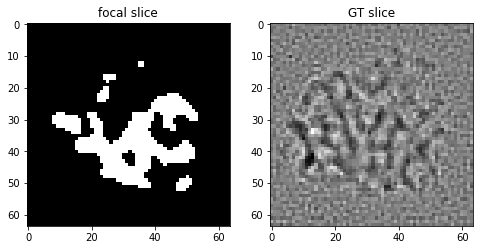

In [26]:
# visualize the data generator

img, msk = train_img_datagen.__next__()

img_num = random.randint(0, img.shape[0]-1)
test_img = img[img_num][...,0]
test_mask = msk[img_num] # 第几个stack
test_mask = np.argmax(test_mask, axis=3)

# n_slice=random.randint(0, test_mask.shape[2])
n_slice = 32
visusalizeIMG(n_slice, test_mask, test_img)

### define the loss, metrics and optimizer for training

In [27]:
wt0, wt1 = 0.5,0.5

import segmentation_models_3D as sm

dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1]))  # default is uniform
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1* focal_loss)  # works for most segmentation jobs


metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]  # metrics for final performance
LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [28]:
# fit the transfer learning model. hyper param of the models

import segmentation_models_3D as sm
import tensorflow.keras as k

encoder_weights = 'imagenet'
BACKBONE = 'vgg16'  # other available models: vgg16, efficientnetb7, inceptionv3, resnet50
AKTIV = 'softmax'  
patch_size = 64
n_classes = 2
channels = 3

LR = 0.0001
optim = k.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.5, 0.5])) # weights for segmentation classes
focal_loss = sm.losses.CategoricalFocalLoss()  # handeling the inbalance dataset
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

### fit the model

In [29]:
# define the callback 

# setting checkpoints
checkpointer = k.callbacks.ModelCheckpoint('./transfer3D/model/3d_unet_transfer.h5', verbose=1, save_best_only=True)


callbacks = [
    #k.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
    k.callbacks.TensorBoard(log_dir = './transfer3D/tensorBoard')]  # save in new folder in hemera. Also update in neptune

In [ ]:
# preprocess the training data
# 可能并不需要

preprocess_input = sm.get_preprocessing(BACKBONE)
X_train_prep = preprocess_input(X_train)  # scale the dataset
X_val_prep = preprocess_input(X_val)

print(X_train_prep.shape, X_val_prep.shape, Y_train.shape)

testImg = X_train_prep[0,...]; testMask = Y_train[0,...]
print(testImg.shape)
print(np.min(testImg[0,...]))  # 这之后数值rescale了
print('before pre:', np.min(X_train), np.max(X_train))
print('after pre:', np.min(X_train_prep), np.max(X_train_prep))

In [31]:
# define the model

model = sm.Unet(BACKBONE, classes=n_classes, 
                input_shape=(patch_size, patch_size, patch_size, channels), # 64，64，64，3. vgg is used for 3 channel images
                encoder_weights=encoder_weights,  # encoder initialized with imagenet
                activation=AKTIV)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
# print(model.summary())
print(model.input_shape)
print(model.output_shape)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv3D)          (None, 64, 64, 64,   5248        ['input_3[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv3D)          (None, 64, 64, 64,   110656      ['block1_conv1[0][0]']           
                                64)                                                         

### train and save model

In [32]:
steps_per_epoch = len(train_img_list) // batch_size
val_steps_per_epoch = len(val_img_list) // batch_size

In [33]:

history = model.fit(train_img_datagen,
                   steps_per_epoch=steps_per_epoch,
                   epochs=10,
                   verbose=1, # ??
                   validation_data=val_img_datagen,
                   validation_steps=val_steps_per_epoch,)

Epoch 1/10
120/120 [==============================] - 93s 617ms/step - loss: 0.6829 - iou_score: 0.6139 - f1-score: 0.7316 - val_loss: 0.8154 - val_iou_score: 0.4926 - val_f1-score: 0.6348
Epoch 2/10
120/120 [==============================] - 72s 602ms/step - loss: 0.6593 - iou_score: 0.6370 - f1-score: 0.7524 - val_loss: 0.7479 - val_iou_score: 0.5167 - val_f1-score: 0.6562
Epoch 3/10
120/120 [==============================] - 73s 604ms/step - loss: 0.6577 - iou_score: 0.6379 - f1-score: 0.7533 - val_loss: 0.7190 - val_iou_score: 0.5334 - val_f1-score: 0.6705
Epoch 4/10
120/120 [==============================] - 71s 591ms/step - loss: 0.6572 - iou_score: 0.6382 - f1-score: 0.7537 - val_loss: 0.6923 - val_iou_score: 0.5648 - val_f1-score: 0.6972
Epoch 5/10
120/120 [==============================] - 71s 590ms/step - loss: 0.6569 - iou_score: 0.6384 - f1-score: 0.7539 - val_loss: 0.6683 - val_iou_score: 0.6157 - val_f1-score: 0.7386
Epoch 6/10
120/120 [==============================] - 7

In [34]:
# save the model

MODEL_PATH = 'E:/EM/demo/3D_Unet_keras/model/'

model.save(MODEL_PATH + 'transferVGG_3d' + '_10_' + '.hdf5')

### visualize the training process

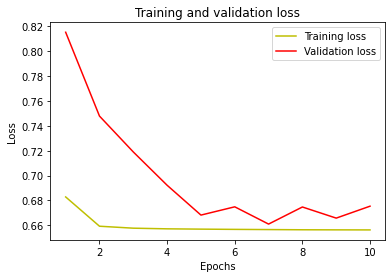

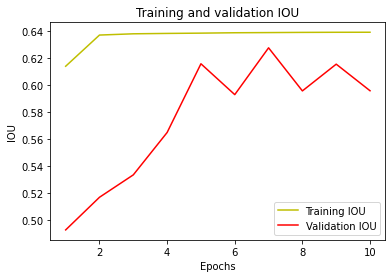

In [35]:
# visualize the loss and IOU loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show() # Save model

### predict the test dataset for IOU

In [8]:
# load in the model

MODEL_PATH = 'E:/EM/demo/3D_Unet_keras/model/'

from keras.models import load_model
my_model = load_model(MODEL_PATH + 'transferVGG_3d' + '_10_' + '.hdf5', compile=False)

In [13]:
# for prediction verify IoU

from keras.metrics import MeanIoU

batch_size = 4  # prediction可以随意开,但也要考虑资源的问题

test_img_datagen = imageLoader(test_img_dir, test_img_list,
                              test_msk_dir, test_msk_list, batch_size)

In [14]:
# verify the generator

test_image_batch, test_mask_batch = test_img_datagen.__next__()  # 同时给出image和mask
print('before:', test_mask_batch.shape)
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4) # convert onehot back to integer
print('after:', test_mask_batch_argmax.shape)

before: (4, 64, 64, 64, 2)
after: (4, 64, 64, 64)


In [15]:
# predict

test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

1/1 [==============================] - 0s 310ms/step


In [16]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.59330374


### predict the test dataset of multiple image

In [17]:
img_num = 15  # the name in test dataset

test_img = np.load(DATA_PATH + '/test/images/image_'+str(img_num)+'.npy')

test_mask = np.load(DATA_PATH + '/test/masks/mask_'+str(img_num)+'.npy')
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

1/1 [==============================] - 1s 945ms/step


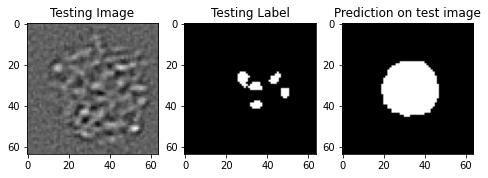

In [19]:
# visualize

n_slice = 10

plt.figure(figsize=(8, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[n_slice,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[n_slice,:,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[n_slice,:,:], cmap='gray')
plt.show()